<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Walk%20With%20Fastai%20(Zach%20Mueller)%20/WWF_Lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai -q --upgrade 

     |████████████████████████████████| 194kB 36.8MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 


In [2]:
!nvidia-smi

Mon Jul 12 22:35:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Image Classification Models from Scratch 

In this lecture we will build a model from scratch with the lowest level api of fastai and plus with bit of Pytorch. 

The dataset we will be using in this lecture is MNIST dataset. 

Low-level api --> `Datasets`

### Getting our data ready!

In [3]:
# Importing the packages we need 
from fastai.vision.all import * 

import torch
from torch import nn 

from fastai.callback.hook import summary 
from fastai.callback.schedule import fit_one_cycle , lr_find 
from fastai.callback.progress import ProgressCallback

from fastai.data.core import Datasets , DataLoaders , show_at 
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize , GrandparentSplitter , parent_label , ToTensor , IntToFloatTensor , Normalize

from fastai.layers import Flatten
from fastai.learner import Learner

from fastai.metrics import accuracy , CrossEntropyLossFlat 

from fastai.vision.augment import CropPad , RandomCrop , PadMode 
from fastai.vision.utils import get_image_files 

In [4]:
# Loading in the data 
path = untar_data(URLs.MNIST)

In [5]:
# Getting the filenames because the (Datasets accepts a list of filenames)
items = get_image_files(path)
items[:5]

(#5) [Path('/root/.fastai/data/mnist_png/training/8/25275.png'),Path('/root/.fastai/data/mnist_png/training/8/22166.png'),Path('/root/.fastai/data/mnist_png/training/8/10561.png'),Path('/root/.fastai/data/mnist_png/training/8/11322.png'),Path('/root/.fastai/data/mnist_png/training/8/55618.png')]

The above `items` consists of a list of filenames that had to be passed into a `Datasets`. 

Since we are going to build everything from low-level api we cant use a DataBlock. 

Let's create a image object which is similar to a `ImageBlock`. 

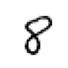

In [6]:
# Creating a image object that creates a PIL image from a given filename 
im = PILImageBW.create(items[0])
im.show()

Breaking down the above function: 
- `PILImageBW` --> creates a PIL image (pass a filepath) 
- `.create` --> takes care of the preprocessing before going in to the model. This is applicable for both X and y, more like a custom implementation for the various inputs. (Building flexible preprocessing inputs)


In [7]:
# Splitting our data using the GrandParentSplitter --> looks for train and valid folder 

splits = GrandparentSplitter(train_name = 'training' , valid_name= 'testing')

`split` --> Creates an instance of the object, where passing the items inside this will results in train and val sets. 

`split` itself doesn't do the splitting function, it accepts a list of items to be passed in. 

In [8]:
# Passing the items into the split method 
splits = splits(items)

In [9]:
splits[0][3] , splits[1][5]

(3, 60005)

In [10]:
# What's inside? (training and validation set [0 ,1] indexes)
sample_train = splits[0][:5]
sample_val= splits[1][:5]

sample_train , sample_val

([0, 1, 2, 3, 4], [60000, 60001, 60002, 60003, 60004])

In [11]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

#### Building a Datasets
The `Datasets` expects, 
- the items we want to use 
- the transforms (how the inputs and outputs should be contructed and spits out) 
- the splits 

In [12]:
# Creating the Datasets 
dsrc = Datasets(items , 
                tfms = [[PILImageBW.create] , [parent_label , Categorize]] , 
                splits = splits)


Breaking the above code:
- `items` --> filenames 
- `tfms` --> `[PILImageBW.create]` we are forming the X in here basically creating images and `[parent_label , Categorize]` in here we want our y to be have the labels of the folder (parent_label --> grab labels from folder) and atlast we want to Categorize them. 
- `splits` --> Splitting into train and valid sets. (goes by indexes) 


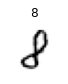

In [13]:
 # We can look at an item in our Datasets with show_at 

show_at(dsrc.train , 3) # accessing train spit and grabbing 3 indexes file


While building a `DataBlock` we passed the `item_tfms` and `aug_tfms` things like RandomResized and etc.. really easily. 

But now we have to construct the whole pipeline by hand without using any of the ready to go functions. 

We need to give ourselves some transforms on the data! These will need to:
- Ensure our images are all the same size
- Make sure our output are the tensor our models are wanting
- Give some image augmentation

In [14]:
# Creating transforms for our data by hand (Left to Right)
tfms = [ToTensor() , CropPad(size = 34 , pad_mode= PadMode.Zeros) , RandomCrop(size = 28)]

- `ToTensor`: Converts to tensor
- `CropPad` and `RandomCrop`: Resizing transforms
- Applied on the CPU via `after_item`

This thing works more like a pipeline, after getting the images converts them into a tensor, apply croping and padding 38x38 and atlast randomly cropped by 28x28 pixels. 

The above is the example of how we did an item tfms, we are getting our data ready to get into the batch. 

Next will see about gpu_tfms otherwise called `batch_tfms`

In [15]:
# Creating the batch tfms 
gpu_tfms = [IntToFloatTensor() , Normalize()]

- `IntToFloatTensor`: Converts to a float
- `Normalize`: Normalizes data (without stats)

Now we have created our `Datasets` the next step would be creating a dataloaders from our datasets. 

In [16]:
# Building our dataloaders 
dls = dsrc.dataloaders(bs = 128 , after_item= tfms , after_batch= gpu_tfms)

Both `after_item` and `after_batch` says apply item tfms everytime a item is called and apply batch tfms when everytime a batch is called. 

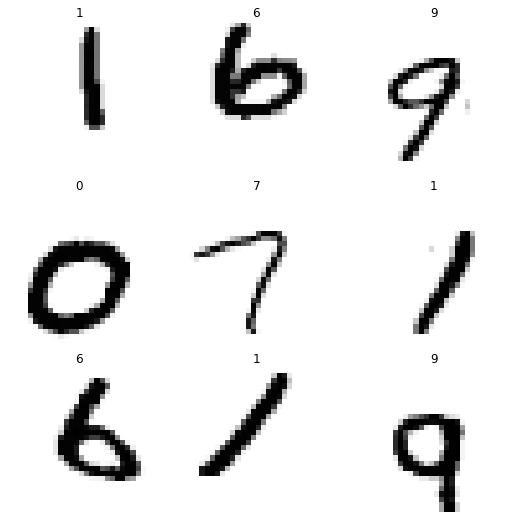

In [17]:
# Visualizing the batch 
dls.show_batch()

Now we got the dataloaders, the next ultimate step would be training the model with the help of a `Learner`. 

But before that let's see what our model will expect and go through. 

In [18]:
# Grabbing one batch 
xb , yb = dls.one_batch() 

# Shape of the x and y 
xb.shape , yb.shape 

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

- `torch.Size([128, 1, 28, 28])` --> its our input x which is composed of 1 channel, by 28x28 pixels and it has 128 items in a one batch. 
- `torch.Size([128]))` --> this is our y which is of 128 different labels. 

In [19]:
# How many classes do we have?
dls.c

10

### The Model

Models are made up of layers where each layer represents a matrix multiplication to end up with our final y. For this image problem we will use a **Convolution layer**, a **Batch Normalization layer**, an **Activation Function** and a **Flattening layer**. On a whole its a convolution neural network. 

#### Convolutional Neural Networks

Imagine a flashlight that is shining over the top left of an image, which covers **5x5** section of pixels at one given moment. This flashlight then slides crosses our pixels at all areas in the picture. 

This flaslight is called a **filter**, which can also be called a **neuron** or **kernel**. The region it is currently looking over is called a **receptive field**. 

This filter is also an array of numbers called **weights** (or **parameters**). 

The depth of this filter must be the same as the depth of our input. In our case it is 1 (in color image its 3). Now once this filter begins moving (or **covolving**) around the image, it is multiplying the values inside this fiilter with the original pixel value of our image (also called **element wise multiplications**). 

These are summed up (in uour case this is just one multiplicaton of **28x28**) to an individual value, which is a representation of just the top left of a image. Now repeat this until every unique location has a number and we get what is called an **activation** or **feature map**. 

This feature map will be 784 different locations, which turns into a 28x28 array

To learn more about CNN: 
- https://www.youtube.com/watch?v=vT1JzLTH4G4
- https://cs231n.github.io/convolutional-networks/
- https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/


In [20]:
# Defining a cnn with pytorch 
def conv(ni , nf):
  '''
  ni --> Is our inputs 
  nf --> number of filters 
  '''
  return nn.Conv2d(ni , nf , kernel_size = 3 , stride = 2 , padding = 1)

`ni` --> is equivalent to the depth of the filter 
`nf` --> is equivalent to how many filters we will be using.

#### Batch Normalization 
This layer will help our inputs to be normalized as we pass in the batch norm layer. 


As we send our tensors through our model, it is important to normalize our data throughout the network. Doing so can allow for a much larger improvement in training speed, along with allowing each layer to learn independantly (as each layer is then re-normalized according to it's outputs)

In [21]:
# Defining our batch norm layer 
def bn(nf):
  return nn.BatchNorm2d(nf)

#### Activation functions 

They give our models non-linearity and work with the weights we mentioned earlier along with a bias through a process called back-propagation. These allow our models to learn and perform more complex tasks because they can choose to fire or activate one of those neurons mentioned earlier. On a simple sense, let's look at the ReLU activation function. It operates by turning any negative values to zero. 


- https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

In [22]:
# Defining our relu function (activation)
def ReLU():
  return nn.ReLU(inplace= True)

#### Flattening 
This layer condenses the outputs of the previous layers and get that values into a single dimension. 

The last bit we need to do is take all these activations and this outcoming matrix and flatten it into a single dimention of predictions. We do this with a Flatten() module. 

### Make a model 
Lets build a model with the components we have and our structure will be, 
- 5 convolutional layers 
- `nn.Sequential` wrap our layers with Sequential model. 
- Starts with conv size 1 --> 34 --> and finish it off with 10 classes.

In [23]:
# Building our model 
model = nn.Sequential(
    conv(1 , 8), 
    bn(8), 
    ReLU(), 
    conv(8 , 16), 
    bn(16), 
    ReLU(), 
    conv(16 , 32), 
    bn(32), 
    conv(32 , 16), 
    bn(16), 
    ReLU(), 
    conv(16 , 10), 
    bn(10), 
    Flatten()
)

In [24]:
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Flatten(full=False)
)

So far we've been using only Pytorch to build our model. 

Now it's time to toss this model into Fastai' Learner class so we can start to train our model. 

In [25]:
# Creting a learner 
learn = Learner(dls , model , loss_func= CrossEntropyLossFlat() , metrics = accuracy)

# Printing the summary of the learner to peek into input and output shapes
learn.summary()

Sequential (Input shape: 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 14 x 14   
Conv2d                                    80         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 7 x 7    
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 4 x 4    
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
____________________________________________________________________________
                     128 x 16 x 2 x 2

`learn.summary` also tells us:
* Total parameters
* Trainable parameters
* Optimizer
* Loss function
* Applied `Callbacks`

SuggestedLRs(valley=tensor(0.0076))

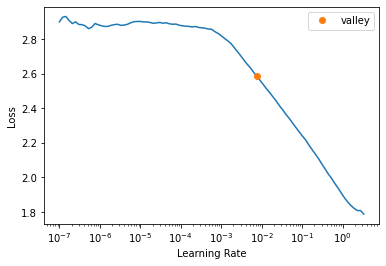

In [26]:
# Finding the learning rate 
learn.lr_find()

In [27]:
learn.fit_one_cycle(3 , lr_max = 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.244958,0.141730,0.958900,01:24
1,0.133976,0.066872,0.981200,01:24
2,0.099609,0.047887,0.987500,01:24


### Simplify it
Our previous model is kinda looks messy with all those layers repeating and we were to type alot. Now we will seek the help of Fastai's `ConvLayer` which contains **Conv2d, BatchNorm2d, and an activation function** in it. 

Lets see how can we make one! 

In [28]:
# Using Fastai's convlayer defining our function 
def conv2(ni , nf):
  return ConvLayer(ni , nf , stride = 2)

In [30]:
conv2(1 , 8)

ConvLayer(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [33]:
# Now let's build our model with the above function 
net = nn.Sequential(
    conv2(1, 8), 
    conv2(8 , 16), 
    conv2(16 , 32), 
    conv2(32 , 16), 
    conv2(16 , 10),
    Flatten()
)

net

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): ConvLayer(
    (0): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(10, eps=1e

In [31]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [32]:
learn.fit_one_cycle(3 , lr_max = 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.233381,0.150095,0.962200,01:24
1,0.110723,0.069759,0.978900,01:24
2,0.087391,0.048840,0.986200,01:26


Alright now we have build our simple conv layers and with other bunch of layers we were able to create a simple model. But we can do better. 

Let's try to recreate a ResNet (kinda) architecture with the things we have learnt so far and see how it goes. 

### ResNet(kinda) 
The ResNet architecture is built with what are known as ResBlocks. 
- Each of these blocks consists of two `ConvLayers`, same as we did before where the number of filters doesnt change.

In [34]:
# Creating a class called ResBlock 
class ResBlock(Module):

  # __init__ runs anytime we call the class
  def __init__(self , nf):
    self.conv1 = ConvLayer(nf ,nf)
    self.conv2 = ConvLayer(nf ,nf)

  # We need a forwarrd because this is defines the working mechanism of the above layers 
  # Where we connect our layers and the data 
  def forward(self , x):
    return x + self.conv2(self.conv1(x))

In [35]:
# Building our ResNet kinda model 
net = nn.Sequential(
    conv2(1,8),
    ResBlock(8),
    conv2(8,16),
    ResBlock(16),
    conv2(16,32),
    ResBlock(32),
    conv2(32,16),
    ResBlock(16),
    conv2(16,10),
    Flatten()
)

net

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (2): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride

Still thats alot of code, now let's cut down some code lines by writing a function 

In [37]:
# Combining a convolution and a ResBlock together
def conv_and_res(ni , nf):
  return nn.Sequential(conv2(ni , nf), ResBlock(nf))

In [ ]:
# Now simplifying our model 
net = nn.Sequential(
    conv_and_res(1 , 8), 
    conv_and_res(8 , 16), 
    conv_and_res(16 , 32), 
    conv_and_res(32 , 16), 
    # Now pass it to the conv layer not the resblock
    conv2(16 , 10), 
    Flatten()
)

net

We have simplified our code and we have a model that something looks similar to a ResNet. 

SuggestedLRs(valley=tensor(0.0063))

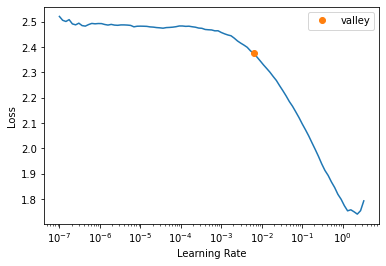

In [39]:
# Creating a learner 
learn = Learner(dls , net , loss_func= CrossEntropyLossFlat() , metrics = accuracy)

# Lr Find 
learn.lr_find()

In [40]:
# Fitting our model 
learn.fit_one_cycle(3 , lr_max = 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.180897,0.364807,0.892900,01:28
1,0.079105,0.062942,0.981200,01:28
2,0.048129,0.026252,0.992500,01:28


In [41]:
learn.path = Path('')
learn.export(fname = 'export.pkl')

# Stochastic Gradient Descent 


SGD is a optimization technique (optimizer), this usually how we fit the model to the data. Let's see a working example with Linear Regression. 

In [46]:
# Importing the needed packages
from fastai.basics import * 
from fastai.torch_core import tensor

import torch 
from torch import nn 

import numpy as np
import matplotlib.pyplot as plt

## Linear Regression 

Fit a line on 100 points, we gotta make a data of 100 points and try to fit a line on those points using SGD. 

In [48]:
n = 100 # data points 

# Creating two columns of 100 data points 
x = torch.ones(n , 2)

# Looking at the len and the shape
x.shape , len(x)

(torch.Size([100, 2]), 100)

In [49]:
x[:5]

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [50]:
# Grabbing the first column and randomize the values in a uniform distribution -1 to 1 
x[: , 0].uniform_(-1., 1)

# Now we looking into 
x[:5]

tensor([[-0.8245,  1.0000],
        [ 0.7852,  1.0000],
        [-0.3721,  1.0000],
        [-0.8602,  1.0000],
        [ 0.0752,  1.0000]])

Any linear model is `y = mx+b` where pretty much m , x and b are matrices. For now we have `x` we gotta get m and b to form our desired equation. 

In [54]:
m = tensor(3., 2)
m.shape , m

(torch.Size([2]), tensor([3., 2.]))

In [55]:
# Random bias 
b = torch.rand(n)
b[:5] , b.shape

(tensor([0.6063, 0.9667, 0.0513, 0.2339, 0.1491]), torch.Size([100]))

In [57]:
# Making our y equation (matrix mul is denoted by @)
y = x@m + b

In [58]:
y

tensor([ 0.1329,  5.3224,  0.9350, -0.3467,  2.3747,  0.2045,  3.3665,  1.1950,
         2.1057,  1.2764,  0.5438,  2.0972,  4.8998,  1.9755,  3.5604,  0.9914,
         3.7613,  1.8895,  3.1424,  2.0598,  4.9209,  4.8683,  3.1144,  4.1123,
         1.6858,  1.8074,  1.9321,  1.0266, -0.0188,  2.8745,  1.8553,  0.3309,
         1.7826,  4.6204,  3.5981,  1.1352,  4.4767,  4.2154,  4.5920,  4.8125,
        -0.2978,  3.2433,  4.3313,  1.9764,  0.3778, -0.2580, -0.2644,  2.6564,
         4.1772,  4.7286,  1.8106, -0.0997,  3.1822,  1.7837,  0.4544,  1.1239,
         5.7065,  3.1568,  1.4715,  4.3191,  4.3539,  3.4685,  0.9733,  2.6395,
         5.2094,  4.1332,  1.1935,  3.0482,  2.1535, -0.1266,  2.1805,  2.5691,
         1.1528,  4.8121,  4.5122,  3.5725,  1.1334,  5.1831,  0.9407,  4.3711,
         3.1538,  1.7787,  0.7056,  2.6485,  0.4267,  1.6892,  3.7501,  3.8957,
         2.9427,  4.2152,  3.3887,  2.3617,  2.4396, -0.1486,  1.8485,  3.3273,
         2.5991,  5.1867, -0.5721,  0.56

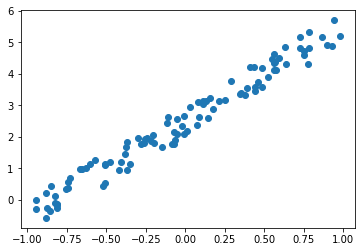

In [59]:
# Plotting our results x and y 
plt.scatter(x[: , 0] , y)

Alright we got a cool looking plot! Now our **weights** should minimize the distance between points and the line. 

We need a loss at first place, so that by minimizing it we can eventually minimize the distane between points and the line. Here we gonna use **mean squared error** which takes distance from `pred` and `y`, square the average. 

Our model should try and predict `m`.

In [ ]:
# Defining our mse loss 
def mse(y_hat , y):
  return ((y_hat - y)**2).mean()|

In [60]:
# Our input (m -> a)
a = tensor(.5 , .75)

Now we gotta make a prediction and calculate the error. 

In [61]:
# MMaking a prediction 
y_pred = x@a

# Calculate the error 
mse(y_pred , y)

TensorBase(4.8779)

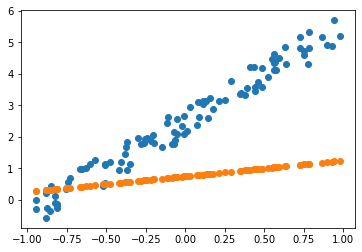

In [63]:
# Lets plot the predictions and the target line 
plt.scatter(x[:, 0] , y)
plt.scatter(x[:, 0] , y_pred)

We can clearly see that the line isn't fitting with our model. Now let's code and try to optimize so it wiil fit the line. 

### Walking down Gradient Descent 
- **Goal**: Minimize the loss function (mse)
- Gradient Descent workflow: 
  - Start with parameters 
  - Move towards new parameters to minimize the function 
  - Take steps in negative direction of gradient function. 

Our goal is to minimize the loss function (mse) by using the gradient descent. 

In [64]:
# Creating some parameters of our inputs 
a = nn.Parameter(a)
a

Parameter containing:
tensor([0.5000, 0.7500], requires_grad=True)

Let's create a function called `update` to check if the current value of `a` is improved and move even closer if it did. 

In [67]:
# Creating the update function 
def update():
  # Getting the predictions
  y_hat = x@a
  # Calculating the loss 
  loss = mse(y , y_hat)

  # Conditionals checking 
  if i % 10 == 0:
    print(loss)
  
  # Activating backprop in our loss (this gives us the gradients)
  loss.backward()
  with torch.no_grad(): # Sets everything to evaluation mode
    a.sub_(lr * a.grad)
    a.grad.zero_()


- `torch.no_grad`: No back propogation (no updating of our weights) 
- `sub_`: Subtracts some value in our case it is (lr * our gradient) 
- `grad.zero_`: Zeros our gradients so upcoming gradients wont add up with the existin one. 

In [68]:
# Learning rate 
lr = 1e-1

In [69]:
# Using the update function 
for i in range(100):
  update()

TensorBase(4.8779, grad_fn=<AliasBackward>)
TensorBase(0.6739, grad_fn=<AliasBackward>)
TensorBase(0.2505, grad_fn=<AliasBackward>)
TensorBase(0.1362, grad_fn=<AliasBackward>)
TensorBase(0.1029, grad_fn=<AliasBackward>)
TensorBase(0.0932, grad_fn=<AliasBackward>)
TensorBase(0.0903, grad_fn=<AliasBackward>)
TensorBase(0.0895, grad_fn=<AliasBackward>)
TensorBase(0.0893, grad_fn=<AliasBackward>)
TensorBase(0.0892, grad_fn=<AliasBackward>)


In [73]:
# This is our new a |
a.detach() # Detach will remove all the gradients and we dont want that during calculating with our x 

tensor([2.9566, 2.5286])

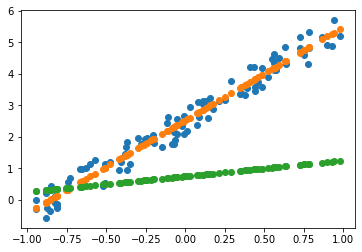

In [74]:
# Plotting 
plt.scatter(x[:,0],y)  # target
plt.scatter(x[:,0], (x@a).detach()) # optimized preds
plt.scatter(x[:,0],y_pred) # previous preds

#### Animate the process 
Let's make some cool animations!

In [75]:
from matplotlib import animation , rc
rc('animation' , html ='jshtml')

In [76]:
# Redoing the process so that we can animate the optimization process 
a = nn.Parameter(tensor(0.5 , 0.75))
a

Parameter containing:
tensor([0.5000, 0.7500], requires_grad=True)

In [80]:
def animate(i):
  update()
  line.set_ydata((x@a).detach())
  return line

In [78]:
# Creating a basic figure 
fig = plt.figure()
plt.scatter(x[:, 0] , y , c='orange')
line, = plt.plot(x[:,0], (x@a).detach())
plt.close()

In [81]:
# Animation!

animation.FuncAnimation(fig , animate , np.arange(0 , 100) , interval = 20)